<img align="right" src="https://raw.githubusercontent.com/GT4SD/gt4sd-core/main/docs/_static/gt4sd_logo.png" alt="logo" width="100" height="100"/>

##  Demo: Regression Transformer in the Generative Toolkit for Scientific Discovery


In [1]:
import logging, sys
logging.disable(sys.maxsize)


from gt4sd.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformer, RegressionTransformerMolecules
)
import mols2grid
from rdkit import Chem
from selfies import encoder
import pandas as pd

Using TensorFlow backend.


# Let us have a look at Buturon, a common herbicide

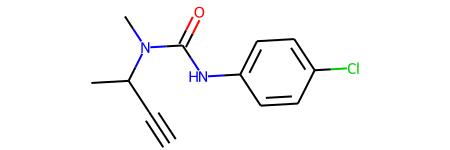

In [2]:
smi = "CC(C#C)N(C)C(=O)NC1=CC=C(Cl)C=C1"
Chem.MolFromSmiles(smi)

## Buturon has a water solubility score of -3.90
## We can predict its ESOL (estimated solubility) value with the RegressionTransformer

In [3]:
config = RegressionTransformerMolecules(algorithm_version="solubility", search="greedy")
target = f"<esol>[MASK][MASK][MASK][MASK][MASK]|{encoder(smi)}"
esol_predictor = RegressionTransformer(configuration=config, target=target)
score = list(esol_predictor.sample(1))[0]
print(f"For Buturuon, the predicted ESOL is {score}")

For Buturuon, the predicted ESOL is -5.2467


#### Ok, we can see that the prediction was decently close but not perfect
#### Now let us try to improve Buturuon to a molecule with higher solubility
#### Note, that we will use the same model to do so!


#### We simply set the hyperparameters for the search and mask undesired parts of the molecule

In [4]:
config = RegressionTransformerMolecules(algorithm_version="solubility", search="sample", temperature=2, tolerance=5)
target = "<esol>-3.534|[C][C][Branch1_3][Ring1][C][#C][N][Branch1_3][epsilon][C][C][Branch1_3][epsilon][MASK][MASK][MASK][MASK][C][=C][Branch1_3][epsilon][Cl][C][=C][Ring1][Branch1_2]"

In [5]:
esol_generator = RegressionTransformer(
    configuration=config, target=target
)
generations = list(esol_generator.sample(5))
generations

[('CC(C#C)N(C)C(O)C#CC=C(Cl)C=C', -4.0012),
 ('CC(C#C)N(C)C(O)CC1C=C(Cl)C=C1', -4.0012),
 ('CC(C#C)N(C1)C1OCl', -4.0012),
 ('CC(C#C)N(C)COOC1C=C(Cl)C=C1', -4.0012),
 ('CC(C#C)N(C)COC=C(Cl)C=C', -4.0012)]

In [6]:
print("\033[1m" "\t\t\tButuruon-inspired molecules with a higher solubility score ")
result = pd.DataFrame({
    "SMILES": [smi] + [s for s,p in generations],
    "Name": ["Buturon"] + 5*["Novel (from RT)"],
    "ESOL": [score] + [round(p, 3) for s,p in generations]
})
mols2grid.display(
    result, tooltip=["Name", "SMILES", "ESOL"], size=(300,150),
    fixedBondLength=25, n_cols=3, width="100%", height=None,
    name='Results'
)

			Buturuon-inspired molecules with a higher solubility score 
